Here we use the components extracted in the previous step and the timestamped data from the behavior

In [61]:
# Load the libraries
import caiman as cm
from caiman.source_extraction import cnmf

import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import json
from scipy.sparse import csc_matrix

from IPython import get_ipython
import IPython




try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the data

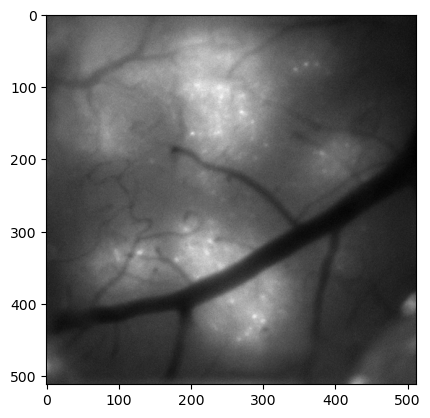

In [2]:
# Load the data
path = 'D:/CaIm/os70/'

# Video
os80 = 'D:/CaIm/os80/memmap__d1_512_d2_512_d3_1_order_C_frames_12000.mmap'  # Replace with your .mmap file path
os70_discr = path + 'memmap__d1_512_d2_512_d3_1_order_C_frames_10496.mmap'
mmap_file_path = os70_discr
Yr, dims, T = cm.load_memmap(mmap_file_path)
#Reshape the data back into a movie:
images = np.reshape(Yr.T, [T] + list(dims), order='F')

# Components data from JSON files
a_data = path + 'A_data.json'
c_data = path + 'C_data.json'

with open(a_data, 'r') as json_file:
    A_list = json.load(json_file)
with open(c_data, 'r') as json_file:
    C_list = json.load(json_file)

# Convert lists back to numpy array and then to sparse matrix if needed
A_array = np.array(A_list)
A_sparse = csc_matrix(A_array)
C_array = np.array(C_list)

# show a frame
plt.imshow(images[0], cmap='gray')
plt.show()

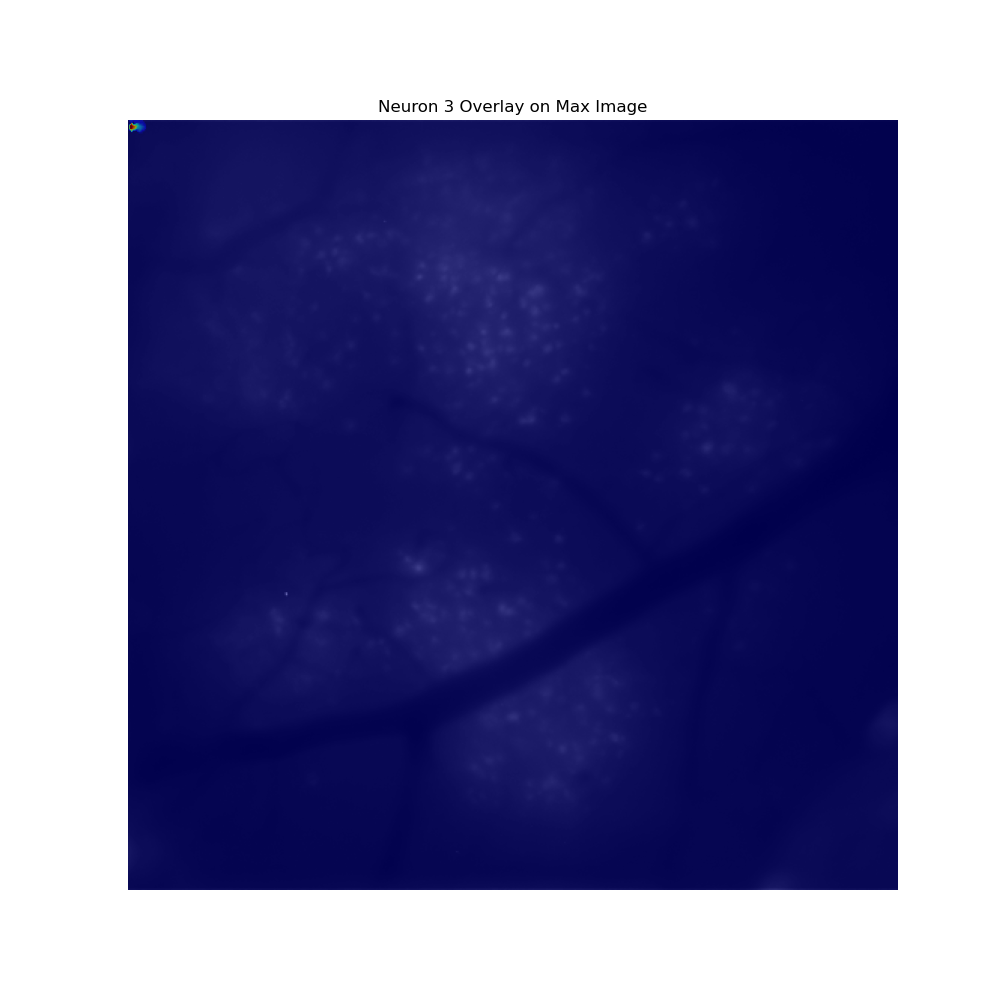

In [11]:
# Make an image with max values of intensity
max_image = np.max(images, axis=0)


# Component number (Python index starts at 0, so component 3 is index 2)
component_num = 2

# Extract spatial component and reshape
spatial_component = A_array[:, component_num].reshape(d1, d2)
# Create a figure
plt.figure(figsize=(10, 10))

# Display the mean image
plt.imshow(max_image, cmap='gray')

# Overlay the spatial component
# Adjust the alpha to make the overlay more or less transparent
plt.imshow(spatial_component, cmap='jet', alpha=0.6)

# Add titles and labels as needed
plt.title(f'Neuron {component_num + 1} Overlay on Max Image')
plt.axis('off')

plt.show()

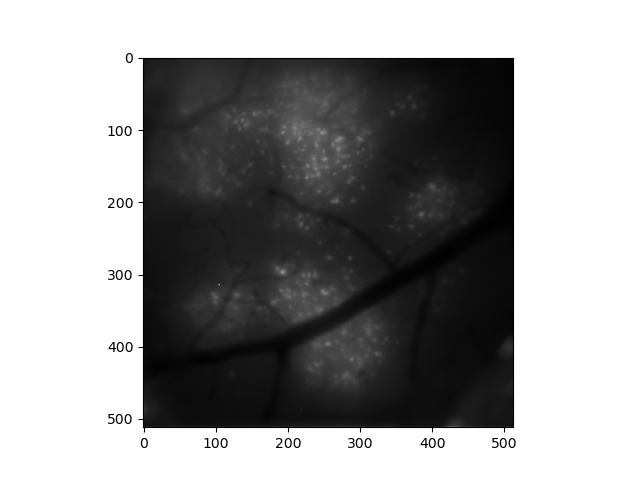

In [16]:
%matplotlib notebook

fig, ax = plt.subplots()
ax.imshow(max_image, cmap='gray')
polygon_points = []

def on_click(event):
    if event.inaxes is not None:
        polygon_points.append((event.xdata, event.ydata))
        ax.plot(event.xdata, event.ydata, 'ro')  # Mark the vertices
        
        if len(polygon_points) == 7:  # When 5 points are chosen
            poly = Polygon(polygon_points, closed=True, edgecolor='r', fill=False)
            ax.add_patch(poly)
            fig.canvas.mpl_disconnect(cid)  # Disconnect the event

            plt.draw()

cid = fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()


In [39]:


def calculate_centroid(A_array, component_num, d1, d2):
    """Calculate the centroid of a component."""
    component = A_array[:, component_num].reshape(d1, d2)
    ys, xs = np.nonzero(component)
    if len(xs) == 0 or len(ys) == 0:
        return None  # or some default value like (0, 0)
    return np.mean(xs), np.mean(ys)

# Assuming A_array shape is (height, width, num_components)
spatial_component = A_array[:, component_num].reshape(d1, d2)
centroids = [calculate_centroid(A_array, i, d1, d2) for i in np.arange(A_array.shape[1])]

# Filter out None values if there are any
centroids = [centroid for centroid in centroids if centroid is not None]


def is_inside_polygon(points, polygon):
    path = Path(polygon)
    return np.array([path.contains_point(point) for point in points])

is_inside = is_inside_polygon(centroids, polygon_points)

# Filter arrays
A_array_filtered = A_array[:, is_inside]
C_array_filtered = C_array[is_inside, :]


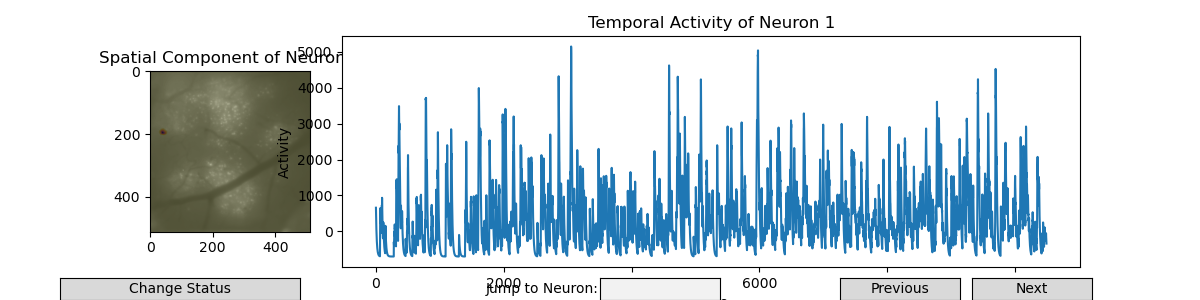

In [60]:
%matplotlib widget

# Original dimentions
d1 = 512
d2 = 512

# Initial component number
component_num = 0

A_array = A_array_filtered
C_array = C_array_filtered

# Plot a certain neuron
def update_plot(component_num):
    spatial_component = A_array[:, component_num].reshape(d1, d2)
    temporal_component = C_array[component_num, :]
    
    axs[0].imshow(max_image, cmap='grey')
    axs[0].imshow(spatial_component, cmap='inferno_r', alpha=0.3)
    axs[0].set_title(f'Neuron location {component_num + 1}')
    
    axs[1].clear()
    axs[1].plot(temporal_component)
    axs[1].set_title(f'Temporal Activity of Neuron {component_num + 1}')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Activity')
    
    plt.draw()

def next_neuron(event):
    global component_num
    component_num = (component_num + 1) % A_array.shape[1]
    update_plot(component_num)

def prev_neuron(event):
    global component_num
    component_num = (component_num - 1) % A_array.shape[1]
    update_plot(component_num)

def jump_to_neuron(text):
    global component_num
    component_num = int(text) - 1
    update_plot(component_num)

def change_status(event):
    status_array[component_num] = 1 if status_array[component_num] == 0 else 0
    print(f"Status of Neuron {component_num + 1}: {status_array[component_num]}")

# Create plot with GridSpec
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 5, figure=fig)  # 1 row, 5 columns

# First subplot (small rectangle) in the first column
ax1 = fig.add_subplot(gs[0, 0])
# Second subplot (long rectangle) spanning the next 4 columns
ax2 = fig.add_subplot(gs[0, 1:])

axs = [ax1, ax2]

update_plot(component_num)

# Adjust button positions
axprev = plt.axes([0.7, 0.0, 0.1, 0.075])
axnext = plt.axes([0.81, 0.0, 0.1, 0.075])
axtextbox = plt.axes([0.5, 0.0, 0.1, 0.075])
axstatus = plt.axes([0.05, 0.0, 0.2, 0.075])

# 
btn_next = Button(axnext, 'Next')
btn_next.on_clicked(next_neuron)

btn_prev = Button(axprev, 'Previous')
btn_prev.on_clicked(prev_neuron)

text_box = TextBox(axtextbox, 'Jump to Neuron:')
text_box.on_submit(jump_to_neuron)

btn_status = Button(axstatus, 'Change Status')
btn_status.on_clicked(change_status)

plt.show()

In [52]:
A_array

(262144, 382)

In [27]:
len(C_array)

247

In [40]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path

fig, ax = plt.subplots()
ax.imshow(max_image, cmap='gray')

# Function to be called when the polygon is selected
def onselect(verts):
    path = Path(verts)
    plt.gca().add_patch(Polygon(verts, color='red', alpha=0.4))
    plt.gcf().canvas.draw_idle()

    # Mark components as rejected if they fall outside the polygon
    rejected_components = []
    for i, spatial_component in enumerate(cnm.estimates.A.T):
        # Check if the center of the component is inside the polygon
        y, x = np.unravel_index(spatial_component.argmax(), dims)
        if not path.contains_point((x, y)):
            rejected_components.append(i)

    print("Rejected components:", rejected_components)

# Lasso selector
lasso = LassoSelector(ax, onselect)
plt.show()


<IPython.core.display.Javascript object>

In [41]:
%matplotlib widget
